<Figure size 1500x1000 with 0 Axes>

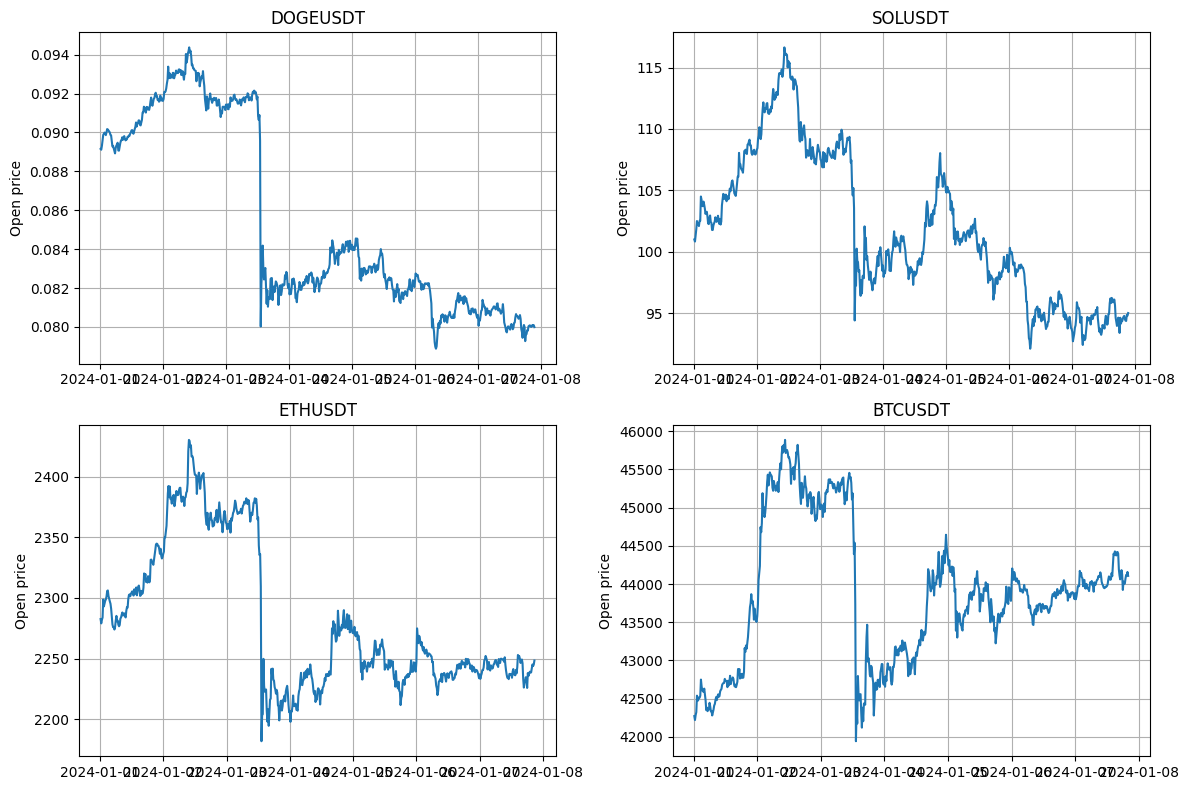

In [11]:
import os
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

path = 'data/crypto'
dir_list = os.listdir(path)

# Calculate the number of rows and columns for the subplots
num_files = len(dir_list)
# num_rows = int((num_files + 1) / 2)  # Ensure there are enough rows for all files
num_rows = 2
num_cols = min(2, num_files)          # Limit to 2 columns

# Create a figure and subplots based on the calculated rows and columns
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 8))

# Flatten the axes array to simplify indexing
axes = axes.flatten()

for i, file_name in enumerate(dir_list, 1):
    file_path = f'data/crypto/{file_name}'
    
    if 'csv' not in file_path: continue
    
    df = pd.read_csv(file_path)

    start = int(dt.datetime(2024, 1, 1).timestamp() * 1000)
    df = df[df['timestamp'] > start]

    y = df['open']
    x = [dt.datetime.fromtimestamp(timestamp) for timestamp in (df['timestamp'] / 1000)]
    
    # Use the i-th subplot
    ax = axes[i - 1]
    ax.plot(x, y)

    ax.grid(True)
    ax.set_ylabel('Open price')
    ax.set_xlabel(None)
    ax.set_title(file_name.split('.')[0])

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# Show the figure
plt.show()
